### Importing the libraries

In [41]:
import tensorflow as tf

import os
import time
from datetime import datetime

import numpy as np 
from sklearn.manifold import TSNE
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

### TensorFlow and Python version

In [2]:
print(str(tf.__version__))

2.1.0


In [3]:
import platform
print(platform.python_version())

3.7.6


### TensorFlow 2 Eager execution

Recall that in TensortFlow 2 eager execution is enabled by default. With eager execution operations are evaluated immediately without building graphs. Operations return concrete values instead of constructing a computational graph to run later.

In [4]:
tf.executing_eagerly()

True

### Loading the MNIST dataset

First we load the MNIST dataset directly from `tf.keras.datasets`. 

By printing the shape of `train_images` and `test_images` we see that we have 60000 training images and 10000 test images. Each MNIST picture consists of 28x28 pixels with each pixel ranging from the integers 0 to 255. 

In [5]:
(train_images, train_labels ), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

print("train_images shape: {}".format(train_images.shape))
print("test_images shape: {}".format(test_images.shape))

print()

print("train_labels shape: {}".format(train_labels.shape))
print("test_labels shape: {}".format(test_labels.shape))

train_images shape: (60000, 28, 28)
test_images shape: (10000, 28, 28)

train_labels shape: (60000,)
test_labels shape: (10000,)


### Reshaping and normalizing the dataset

The neural network will have convolutional layers hence we have to reshape our data and add a "redundant" channel dimension 1 (MNIST doesn't have color)).

We also normalize the data to lie between 0 and 1 and then binarize them into black and white pixels only.

In [6]:
# reshaping dataset
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype("float32")
test_images = test_images.reshape(test_images.shape[0],28,28,1).astype("float32")

# normalize dataset: each MNIST image consists of 28x28 integers between 0-255
train_images /= 255.
test_images /= 255.

# binarization: pixel values >= 0.5 become 1 | pixel values < 0.5 become 0
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.

test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.


### Shuffle dataset and create batches

**(Stochastic) Gradient Descent** works properly when the instances in the training set are **i.i.d**. An easy way to ensure this, is to shuffle the training data. We can do so by first creating a `TensorSliceDataset` object of  the tain and test data respectively and then applying the`shuffle()` method on them. 

We will also split our training and test data into **batches** by applying the `batch()` method.

For the sake of reproducibility we set `seed=42` in the method `shuffle()`.

In [7]:
# initialize varibles for shuffling dataset and creating batches
TRAIN_BUF = 60000
BATCH_SIZE = 100
TEST_BUF = 10000

train = (train_images,train_labels)
test = (test_images,test_labels)

# shuffle dataset and create batches
train_dataset = tf.data.Dataset.from_tensor_slices(train).shuffle(TRAIN_BUF,seed=42).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test).shuffle(TEST_BUF,seed=42).batch(BATCH_SIZE)


The last code cell shuffled our dataset and split it into batches of size `BATCH_SIZE`. When we iterate through **the first 3 items** in `train_dataset`, we see the shape of our batches is indeed what we wanted them to be.

In [8]:
i=0
for (image_batch,label_batch) in train_dataset.take(3):
    i+=1
    print("Batch {}: ".format(i), "Image Batch Shape: ", image_batch.shape,
          "| Label Batch Shape: ", label_batch.shape)

Batch 1:  Image Batch Shape:  (100, 28, 28, 1) | Label Batch Shape:  (100,)
Batch 2:  Image Batch Shape:  (100, 28, 28, 1) | Label Batch Shape:  (100,)
Batch 3:  Image Batch Shape:  (100, 28, 28, 1) | Label Batch Shape:  (100,)


Let's confirm quickly that the labels match the images.

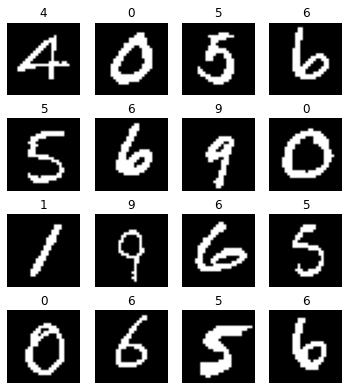

In [9]:
# extract images and label tensors from first batch
[(images,labels)] = list(iter(train_dataset.take(1)))

# plot first 16 images out of the 100 in the batch
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.subplots_adjust(top=1.4) 
    plt.imshow(images[i,:,:,0],cmap="gray")
    plt.title(str(np.array(labels[i])))
    plt.axis("off")

### How Variational Autoencoders work in a nutshell

### Network Architecture

### Refresher on Transposed Convolution
In case you are not familiar with **Transposed Convolution**, I recommend looking at these [visualizations](https://github.com/vdumoulin/conv_arithmetic) on github.

In [10]:
# define convolutional variational autoencoder model class
class CVAE(tf.keras.Model):
    def __init__(self,latent_dim):
        super(CVAE,self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28,28,1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2,2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2,2), activation='relu'),
                tf.keras.layers.Flatten(),
                # no activation since mean and log_var can be either pos. or neg.
                tf.keras.layers.Dense(latent_dim + latent_dim)

            ]
        )
        
        self.generative_net = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7,7,32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64,
                    kernel_size=3,
                    strides=(2,2),
                    padding="SAME",
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32,
                    kernel_size=3,
                    strides=(2,2),
                    padding="SAME",
                    activation='relu'),
                # no activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=(1,1), padding="SAME")

            ]
        )
    
    # here only decorate sample method with @tf.functionthe 
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(BATCH_SIZE, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    
    #methods below will be decorated with @tf.function in trainining loop
    def encode(self, x):
        mean, logvar =tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    
    def reparametrize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar *.5) + mean
    
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        
        return logits

### The Loss Function

Variational Autoencoders are trained to maximize the evidence lower bound **(ELBO)** which is a lower bound to the marginal log likelihood, i.e. 

$\log p(x) \geq ELBO = \mathbb{E}_{q(z|x)}\bigg[\frac{p(x,z)}{q(z|x)}\bigg] = \mathbb{E}_{q(z|x)} \bigg[ \log p(x|z) + \log p(z) - \log q(z|x) \bigg]$.

$= \mathbb{E}_{q(z|x)} \bigg[ \log p(x|z) \bigg] + \mathbb{E}_{q(z|x)} \bigg[ \log p(z) - \log q(z|x) \bigg]$

The **first term** 

$\mathbb{E}_{q(z|x)} \bigg[ \log p(x|z) \bigg]$

can be interpreted as a reconstruction loss. We can approximate it with a simple Monte Carlo estimate

$\log p(x|z)$ 

and since our input image is binary we have that $\log p(x|z)$ is the cross entropy loss of of our decoder with respect to the "labels" $x$.

The **second term** is the latent loss. Mathematically it is the (negative of the) **KL-Divergence** of the two gaussians $q(z|x)$ and $\log p(z)$ which measures how far these distirbutions are apart. It has an analytic solution

$\mathbb{E}_{q(z|x)} \bigg[ \log p(z) - \log q(z|x) \bigg]  = -\frac{1}{2} \sum_{i=1}^K 1 + \log(\sigma_i^2) - \sigma_i^2 - \mu_i^2$

where $K$ is the dimension of $z$ and $\sigma_i$ and $\mu_i$  the variance and mean of $z_i$ respectively under $q(z|x)$.


In [11]:
# use adam optimizer
optimizer = tf.keras.optimizers.Adam(1e-4)

# computes log of normal density
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample -mean)**2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis
    )

# computes loss of model for batch x
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparametrize(mean, logvar)
    x_logit = model.decode(z)
    
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

# computes and applies gradients of loss with resoect to model weights
def get_compute_apply_gradients():
    @tf.function
    def compute_apply_gradients(model, x):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return compute_apply_gradients 

### Trainining
* We will train for **100 epochs**
* 

### Generating Images
Our model can generate **NEW IMAGES**. We would like to see what kind of images our model would generate after every epoch. We do this by:
* specifying the **numbers of examples** we want to generate in total at each epoch (in `num_examples_to_generate`)
* **sampling the latent vectors** form unit gaussian prior $p(z)$ (reference to these samples is `random_vector_for_generation`)
* after a certain epoch **feeding the generator** of the model each $z$ in `random_vector_for_generation`  and turn it into logits of $p(x|z)$ which is a Bernoulli Distribution on the pixels of an image
* **plotting the resulting Bernoulli distribution** $p(x|z)$ for each latent vecotr $z$

**Recall:** The Bernoulli distribution $=p(x|z)$ assigns each pixel $i$ a probabilty $\theta_i$ (the probabilty that the pixel is white). The expected image is  $\mathbb{E}_{p(x|z)}[ x ] = \theta$. We can thus see the expected image by plotting the generated probabilities $\theta$. The generator $p(x|z)$ outputs these probabilities $\theta$.

In [12]:
def generate_images(model, epoch, latent_vectors,path=None):
    predictions = model.sample(latent_vectors)
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4,4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap="gray")
        plt.axis("off")
   
    if path:
        plt.savefig(os.path.join(path,"image_at_epoch_{:04d}.png".format(epoch)))
    
    plt.show()

In [13]:
def generate_image_directory():
    date = datetime.now() # datetime object containing current date and time
    date_string = date.strftime("d:%d-m:%m-%H:%M:%S")

    dirName = "trainingImages"
    path = os.path.join(dirName, date_string)

    os.makedirs(path)
    if os.path.exists(dirName):
        print("Directory with path {} is available to store training images.\n".format(path))
    else:    
        raise Exception("Directory for trainining images could not be created")
    
    return path

### Training

In [14]:
def train(loss_func, save_images=False, create_checkpoints=False, restore_model=False):
    # if save_images==True: create directory to save images
    if save_images==True:
        path = generate_image_directory()
    else:
        path = None
    
    # if restore_model==True: restore model weights
    if restore_model==True: 
        if manager.latest_checkpoint:
            checkpoint.restore(manager.latest_checkpoint)
            print("Restored Model from "
                  "{}\nContinue with training\n".format(manager.latest_checkpoint))
        else:
            raise Exception("Model could NOT be restored.\n")
    
    # generate images once before training
    generate_images(model, 0, random_vector_for_generation, path)
    
    # start training loop
    compute_apply_gradients = get_compute_apply_gradients()
    for epoch in range(1,EPOCHS+1):
        print("Epoch: {}".format(epoch))
        start_time = time.time()
        
        step = 1 
        for train_images, train_labels in train_dataset:
            print("\rstep: {}/{}".format(step, steps_per_epoch),end="")
            compute_apply_gradients(model, train_images)
            step += 1
            
        end_time = time.time()
        
        if create_checkpoints == True:
            manager.save()
            
        # print metrics and generate and save images
        if epoch % 1 == 0:
            loss = tf.keras.metrics.Mean()
            for test_images, test_labels in test_dataset:
                loss(loss_func(model, test_images))
                
            elbo = -loss.result()
            display.clear_output(wait=False)
            print("Test set ELBO: {}\n"
                  "Time passed for current epoch: {}".format(elbo, end_time-start_time)
                 )
            generate_images(model, epoch, random_vector_for_generation, path)
        
        
        
    

In [15]:
EPOCHS = 1
steps_per_epoch = len(list(iter(train_dataset)))
latent_dim = 50

In [16]:
# initialize random latent vector for image generation (after training)
num_examples_to_generate = 16
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate,latent_dim],seed=42)

In [17]:
optimizer = tf.keras.optimizers.Adam(1e-4)
model = CVAE(latent_dim)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(checkpoint=checkpoint,directory="training_checkpoints2",max_to_keep=3)

#train(loss_func=compute_loss,save_images=False, create_checkpoints=True,restore_model=True)

In [18]:
checkpoint.restore(manager.latest_checkpoint)
print("Restored Model from "
      "{}\nContinue with training\n".format(manager.latest_checkpoint))

Restored Model from training_checkpoints2/ckpt-432
Continue with training



# Visualizing the latent space with t-SNE

In [ ]:
(images, labels) = iter(test_dataset.unbatch().batch(10000)).next()
print(images.shape,labels.shape)

In [ ]:
(means, log_vars) = model.encode(images)
print(means.shape,log_vars.shape)

In [ ]:
# perform t-sne on latent variables (means) of test dataset
X = np.array(means)
vis_latent = TSNE(n_components=2, random_state=42).fit_transform(X)

# perform t-sne on original input images of test dataset
X = np.array(tf.reshape(images,(images.shape[0],-1)))
vis_input = TSNE(n_components=2, random_state=42).fit_transform(X)

vis_latent.shape

In [ ]:
# set style sheet and figsize
plt.style.use('seaborn-white')
plt.figure(figsize=(20,5))

# plot t-sne for latent variables
plt.subplot(1,2,1) 
vis_latent_x = vis_latent[:,0]
vis_latent_y = vis_latent[:,1]
scatter = plt.scatter(vis_latent_x, vis_latent_y, c=labels, cmap=plt.cm.get_cmap("jet", 10),s=0.1)
plt.title("t-SNE For Latent Variables")
ax = plt.gca()
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Classes",frameon=True,prop={'size': 7})
ax.add_artist(legend1)
plt.subplots_adjust(top=1.4)
plt.clim(-0.5, 9.5)

# plot t-sne for original input images
plt.subplot(1,2,2)
vis_input_x = vis_input[:,0]
vis_input_y = vis_input[:,1]
plt.scatter(vis_input_x, vis_input_y, c=labels, label=labels, cmap=plt.cm.get_cmap("jet", 10),s=0.1)
plt.title("t-SNE For Original Input Images")
ax = plt.gca()
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Classes",frameon=True,prop={'size': 7})
ax.add_artist(legend1)
plt.subplots_adjust(top=1.4)
plt.clim(-0.5, 9.5)

plt.show()

# Exploring the latent variables

Say we have an input image $x$ of a digit 2. After encoding the image with `model.encode(x)` we can access a 1-D tensor of means which we will refer to as $z$ of dimension `latent_dim`. We could  generate new image from $z$ simply with `model.decode(z,apply_sigmoid=True)` (skipping the sampling from the Gaussian which has mean $z$). It would be nice if some latent variable $z_j$ encodes a high level feature in the generative process such as rotation, style or size of the digit. 

In the next section we will explore whether this is the case.

### Getting one image for each digit class

We will investigate the information of the latent variables for each digit. Meaning we will collect one sample image for each digit class and store it an array for later investigation.

In [112]:
samples_per_class = []
digit_class = []

for image,label in train_dataset.unbatch():
    if len(digit_class) == 10: break
        
    if int(label) not in digit_class:
        samples_per_class.append(image)
        digit_class.append(int(label))

# verify with a plot that we have one image per class
for i in range(10):
    image = samples_per_class[i]
    plt.subplot(1,10,i+1)
    plt.imshow(image[:,:,0],cmap="gray")
    plt.axis("off")

### Getting new latent variables
We will define a fucntion `get_new_latents()` that will take as input an image `image`, an index `j` between 1 and `latent_dim` for the latent variable to be changed, an index `i` between 1 and 17 that specifies the amount and direction of change and a hyperparmater `eps`.

More precisely `get_new_latents(image, j, i, eps)` will return a 1-D tensor that results after varying the j-th component of  `model.encode(image)[0]` (the mean parameters of the posterior gaussian) by  `eps * (i-9) * tf.exp(model.encode(image)[1])`. Recall that `tf.exp(model.encode(image)[1])` is the standard deviation of the gaussian posterior in the genrative process. 

**Note:** The number 9 is the median of 17 and ensure we vary the j-th component in both directions proprtional to the standard deviation.

In [133]:
def get_new_latents(image, j, i, eps=1):
    means , logvars = model.encode(tf.expand_dims(image,0))
    new_latents = np.array(means)
    new_latents[0,j] += eps * (i - 9) * tf.exp(logvars[0,i])
    return new_latents

### Plotting the new images
Next we will define a function `explore_latents()` that will take as input an image `image` and a hyperparamter `eps` and plot for each variable `j` between 1 and `latent_dim` one row of 17 generated images where each generated image is generated after varying the j-th latent variable.
    

In [210]:
def explore_latents(image,latents=(0,latent_dim-1),eps=1):
    fig, axes = plt.subplots(nrows=latents[1]-latents[0], ncols=17, figsize=(20, 20))
    
    for j in range(latents[0],latents[1]+1):
        for i in range(1,17+1):
            new_image = model.sample(get_new_latents(image,j,i,eps=1))
            plt.subplot(latents[1]-latents[0]+1,17,(j-latents[0])*17+i)
            plt.imshow(new_image[0,:,:,0],cmap="gray")
            ax = plt.gca()
            ax.set_yticks([])
            ax.set_xticks([])
            if i == 1: ax.set_ylabel("variable {}".format(j), rotation=90, size="large")


    rows = ["variable {:d}".format(i) for i in range(latents[0],latents[1]+1)]
    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=90, size="large")

    plt.show()

(-0.5, 27.5, 27.5, -0.5)

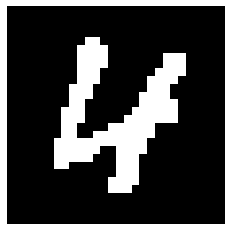

In [213]:
image = samples_per_class[0]
plt.imshow(image[:,:,0],cmap="gray")
plt.axis("off")

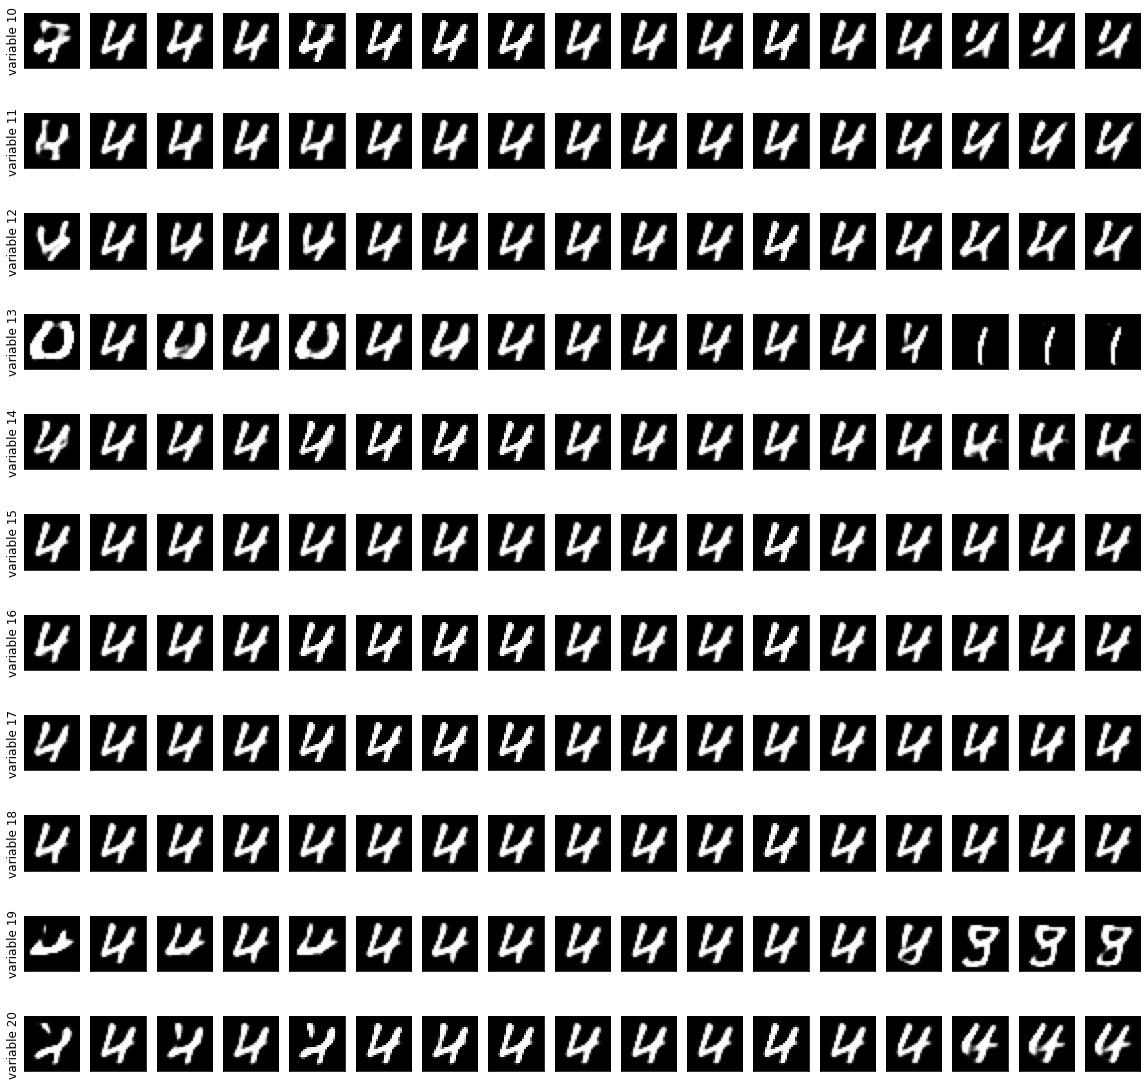

In [214]:
explore_latents(image=image,latents=(10,20))

(-0.5, 27.5, 27.5, -0.5)

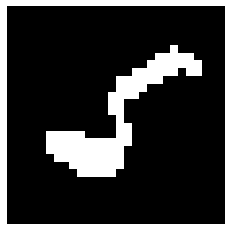

In [215]:
image = samples_per_class[1]
plt.imshow(image[:,:,0],cmap="gray")
plt.axis("off")

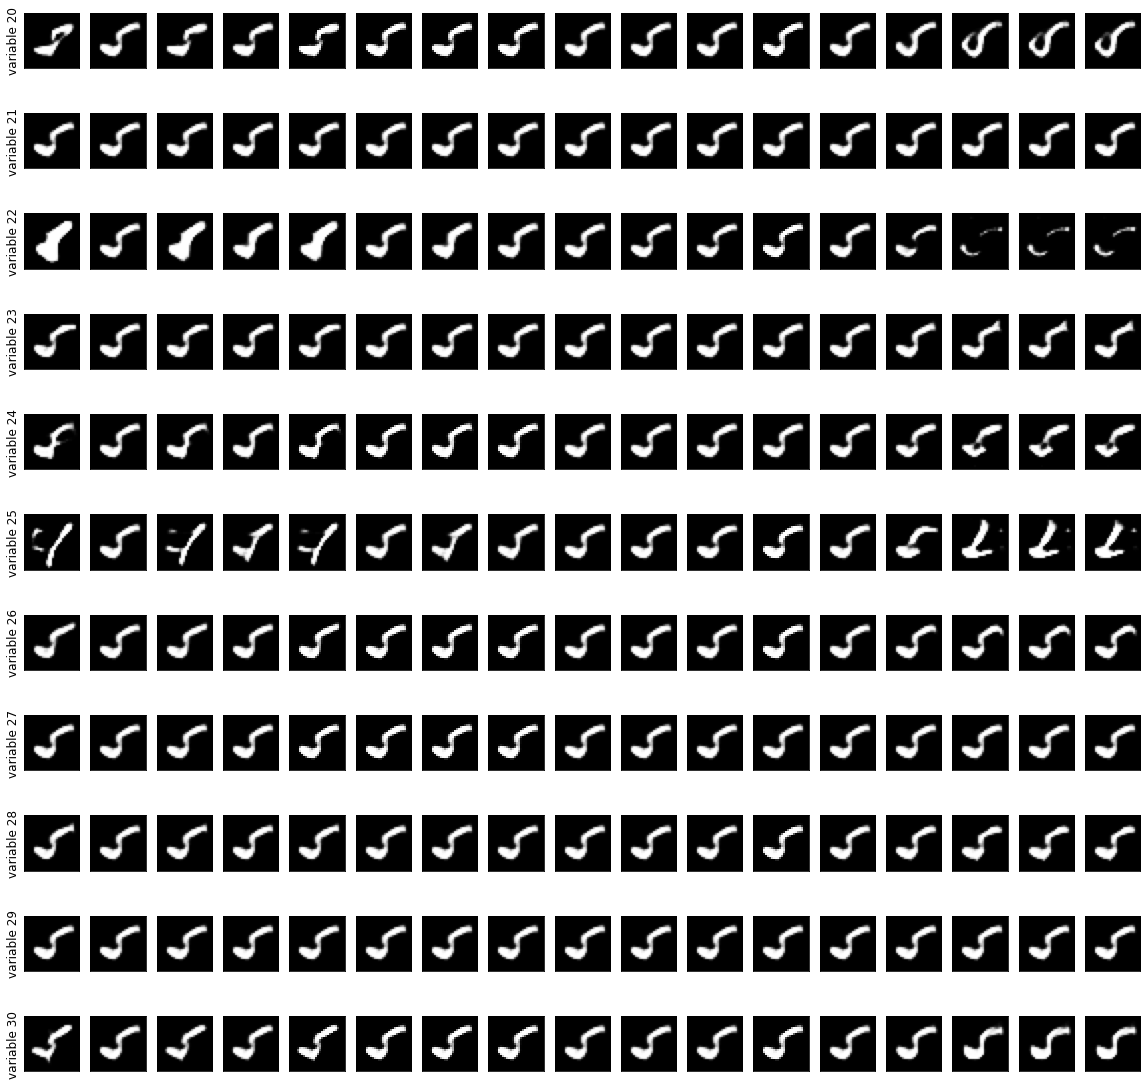

In [218]:
explore_latents(image=image,latents=(20,30))

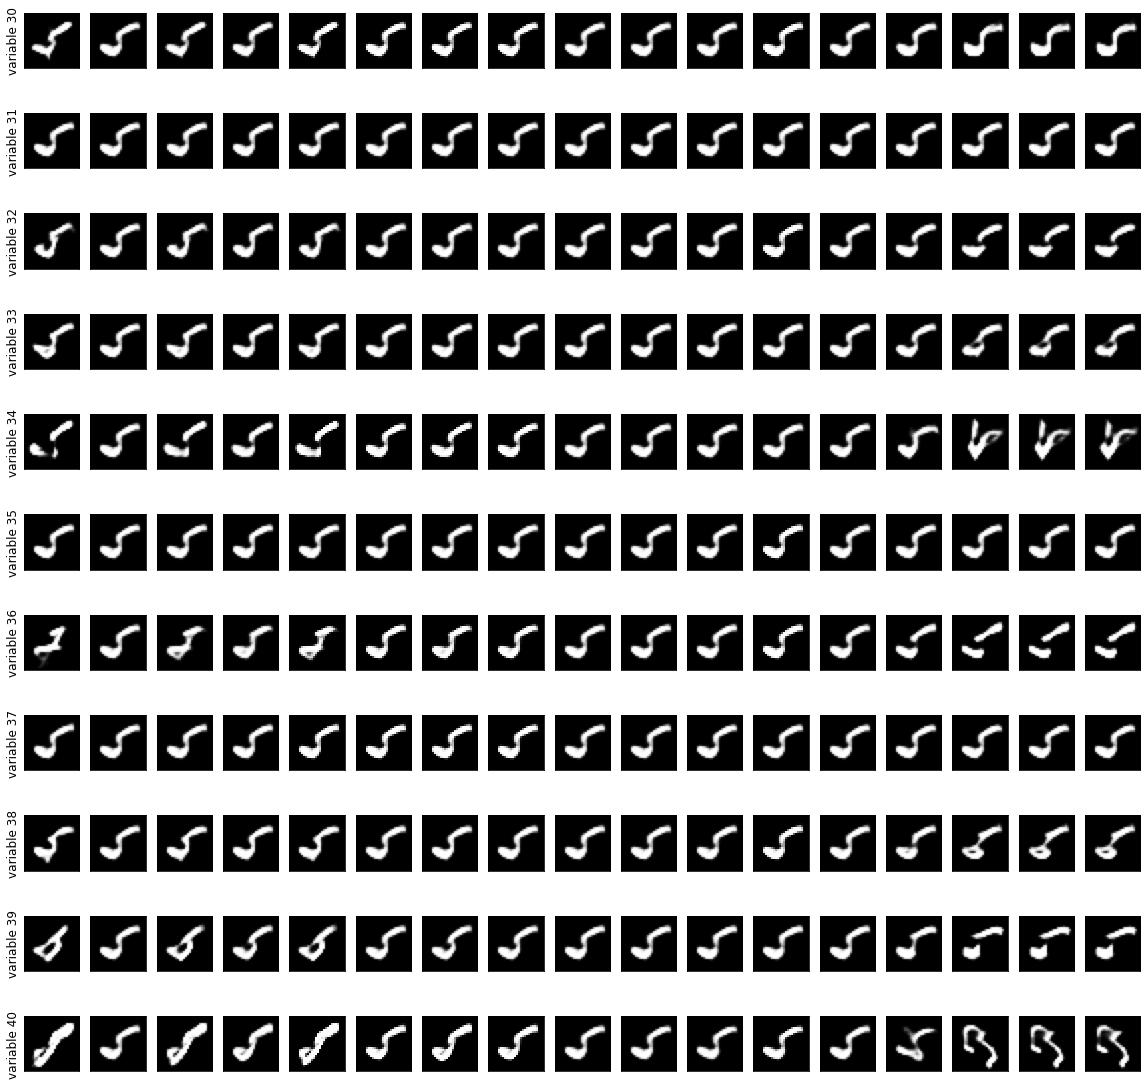

In [219]:
explore_latents(image=image,latents=(30,40))

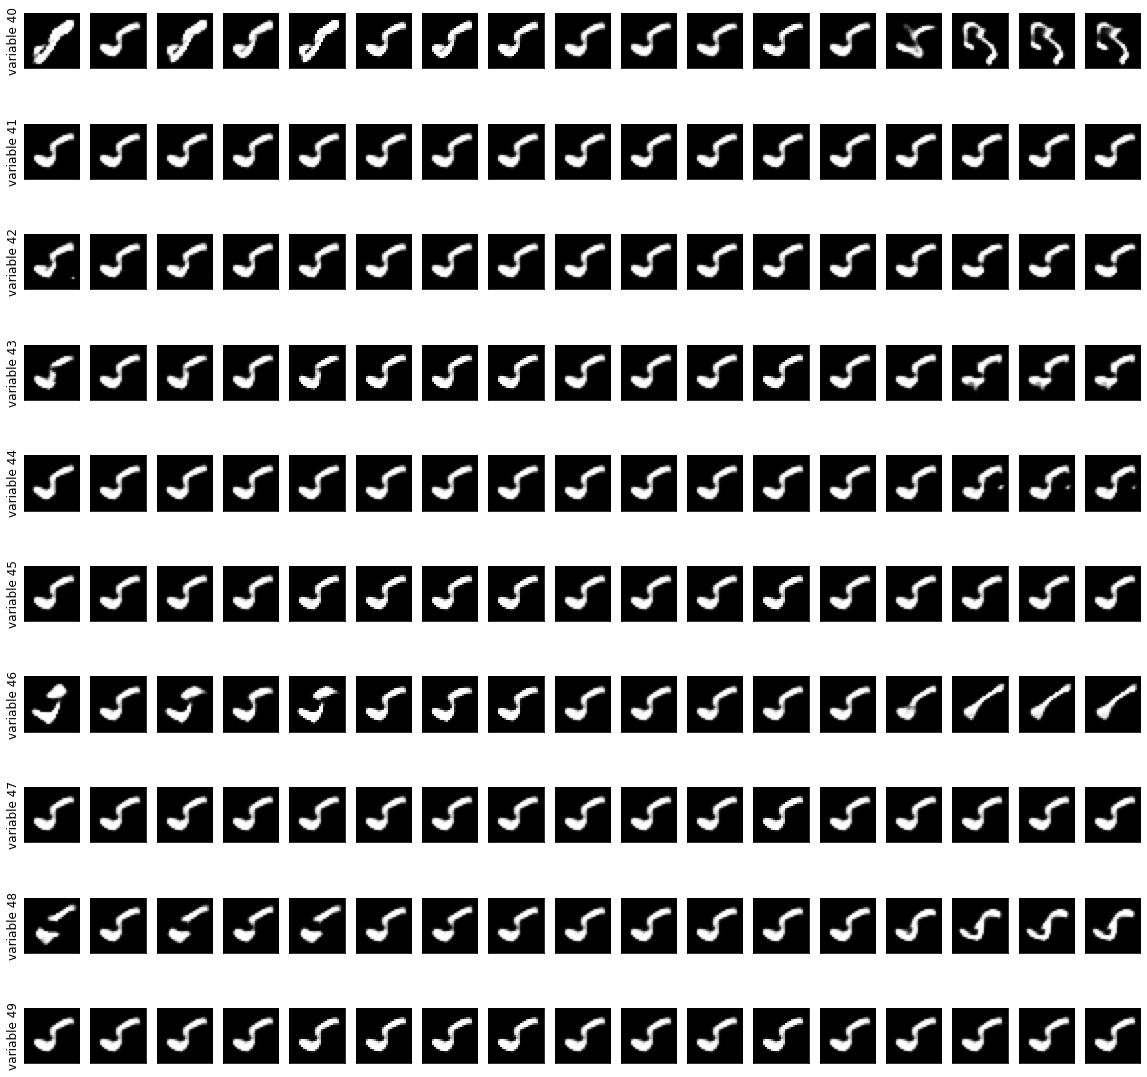

In [221]:
explore_latents(image=image,latents=(40,49))